In [ ]:
# Installing the necessary modules
#!pip install pystan
#!pip install Cython
#!pip install prophet

In [1]:
# Importing the necessary modules
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import prophet
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
#from .autonotebook import tqdm as notebook_tqdm

import warnings
warnings.simplefilter(action='ignore')

import yfinance as yf
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
yf.pdr_override() # <== that's all it takes :-)

In [2]:
# Defining the Time Frame
start = dt.datetime(2020,1,1)
end = dt.datetime.now()

In [3]:
# Loading the Training stock data
ticker = 'AAPL'
data = yf.download(ticker, start, end)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152641,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018692,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675285,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844360,132079200
...,...,...,...,...,...,...
2023-12-19,196.160004,196.949997,195.889999,196.940002,196.940002,40714100
2023-12-20,196.899994,197.679993,194.830002,194.830002,194.830002,52242800
2023-12-21,196.100006,197.080002,193.500000,194.679993,194.679993,46482500


In [4]:
# Exporting the data dataframe as csv file
data.to_csv("apple stock prices.csv")

In [5]:
data.reset_index(inplace=True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152641,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018692,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675285,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844360,132079200
...,...,...,...,...,...,...,...
998,2023-12-19,196.160004,196.949997,195.889999,196.940002,196.940002,40714100
999,2023-12-20,196.899994,197.679993,194.830002,194.830002,194.830002,52242800
1000,2023-12-21,196.100006,197.080002,193.500000,194.679993,194.679993,46482500
1001,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800


In [6]:
data.columns.tolist()

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [7]:
# Extracting the required data
needed_data = data[['Date','Close']]
needed_data.head(5)

,Date,Close
0,2020-01-02,75.087502
1,2020-01-03,74.357498
2,2020-01-06,74.949997
3,2020-01-07,74.597504
4,2020-01-08,75.797501


In [8]:
# Renaming the columns
needed_data.columns = ["ds", "y"]
needed_data

,ds,y
0,2020-01-02,75.087502
1,2020-01-03,74.357498
2,2020-01-06,74.949997
3,2020-01-07,74.597504
4,2020-01-08,75.797501
...,...,...
998,2023-12-19,196.940002
999,2023-12-20,194.830002
1000,2023-12-21,194.679993
1001,2023-12-22,193.600006


In [9]:
# Check column types
needed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1003 non-null   datetime64[ns]
 1   y       1003 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


In [10]:
estimated_days=91
df0 = needed_data.copy()
needed_data = needed_data[:-estimated_days]
needed_data

,ds,y
0,2020-01-02,75.087502
1,2020-01-03,74.357498
2,2020-01-06,74.949997
3,2020-01-07,74.597504
4,2020-01-08,75.797501
...,...,...
907,2023-08-10,177.970001
908,2023-08-11,177.789993
909,2023-08-14,179.460007
910,2023-08-15,177.449997


In [11]:
# Prepare Prophet() model and apply fit() method to that dataframe
df_prophet = prophet.Prophet(changepoint_prior_scale=0.15,yearly_seasonality=True,daily_seasonality=True)
df_prophet.fit(needed_data)

20:56:53 - cmdstanpy - INFO - Chain [1] start processing
20:56:54 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# I am using here 2 * estimated_days: half of it has actual prices to compare with trend values. 
# The second half are new estimated future values.
df_forecast = df_prophet.make_future_dataframe(periods= estimated_days*2, freq='D')

#Forecast future prices
df_forecast = df_prophet.predict(df_forecast)
df_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,77.182257,76.676592,89.026448,77.182257,77.182257,5.837358,5.837358,5.837358,21.728941,...,1.055070,1.055070,1.055070,-16.946653,-16.946653,-16.946653,0.0,0.0,0.0,83.019615
1,2020-01-03,76.833303,76.201984,88.824634,76.833303,76.833303,5.510488,5.510488,5.510488,21.728941,...,0.970472,0.970472,0.970472,-17.188925,-17.188925,-17.188925,0.0,0.0,0.0,82.343791
2,2020-01-06,75.786440,74.417683,87.114164,75.786440,75.786440,5.060303,5.060303,5.060303,21.728941,...,1.155894,1.155894,1.155894,-17.824533,-17.824533,-17.824533,0.0,0.0,0.0,80.846743
3,2020-01-07,75.437485,73.822145,86.551905,75.437485,75.437485,4.823646,4.823646,4.823646,21.728941,...,1.090033,1.090033,1.090033,-17.995328,-17.995328,-17.995328,0.0,0.0,0.0,80.261131
4,2020-01-08,75.088531,73.460059,86.008967,75.088531,75.088531,4.749747,4.749747,4.749747,21.728941,...,1.160766,1.160766,1.160766,-18.139960,-18.139960,-18.139960,0.0,0.0,0.0,79.838278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2024-02-10,170.169691,136.712650,228.297619,125.896347,216.290200,12.087207,12.087207,12.087207,21.728941,...,-2.716116,-2.716116,-2.716116,-6.925618,-6.925618,-6.925618,0.0,0.0,0.0,182.256898
1090,2024-02-11,170.262798,136.144498,229.157604,125.115235,217.046143,12.154930,12.154930,12.154930,21.728941,...,-2.716119,-2.716119,-2.716119,-6.857892,-6.857892,-6.857892,0.0,0.0,0.0,182.417728
1091,2024-02-12,170.355905,140.092333,235.484674,124.919872,217.802086,16.027645,16.027645,16.027645,21.728941,...,1.155894,1.155894,1.155894,-6.857190,-6.857190,-6.857190,0.0,0.0,0.0,186.383550
1092,2024-02-13,170.449011,138.919027,232.842142,124.385060,218.558029,15.896464,15.896464,15.896464,21.728941,...,1.090033,1.090033,1.090033,-6.922511,-6.922511,-6.922511,0.0,0.0,0.0,186.345475


In [13]:
#Investigating predicted data for anomalies
df_forecast.to_csv("investigate.csv")

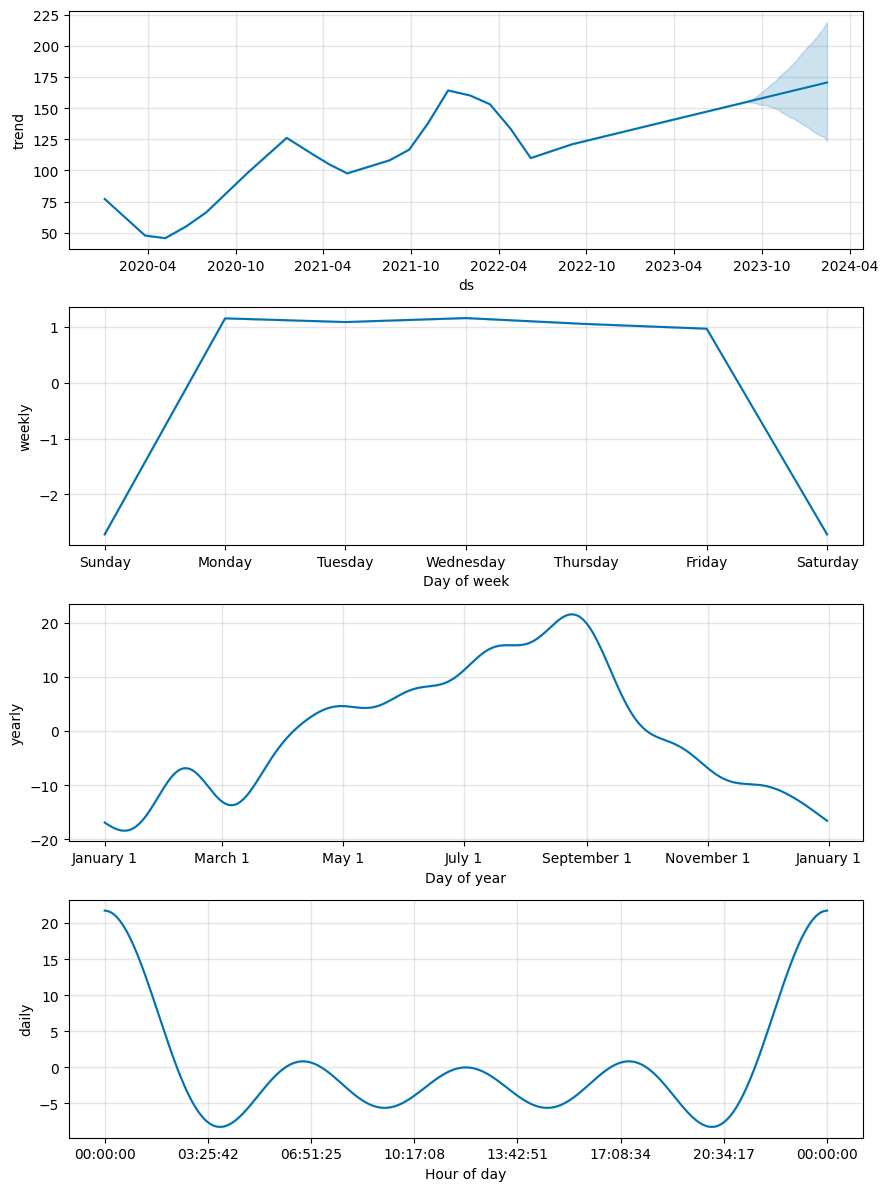

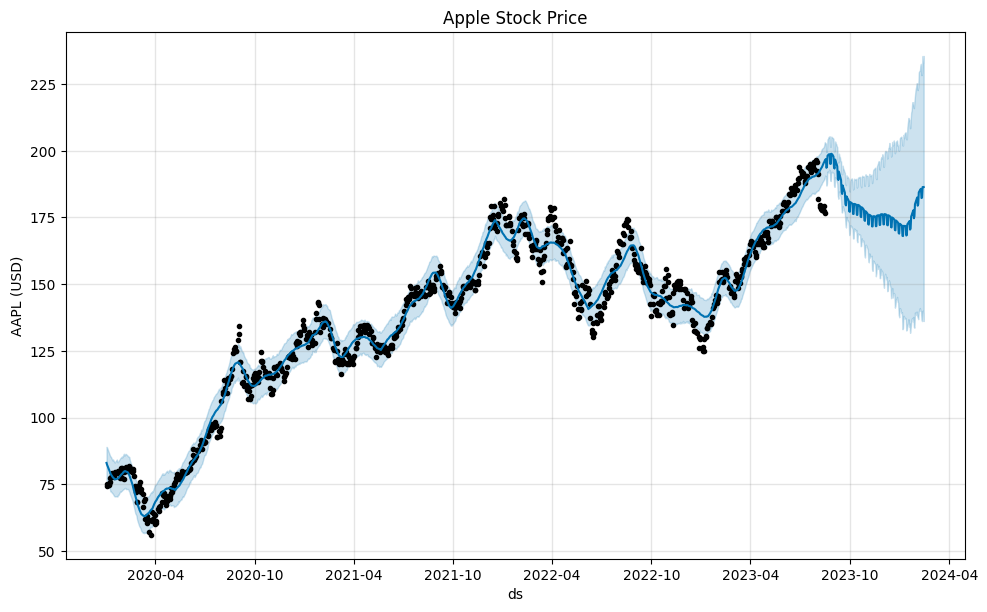

In [14]:
# plot_components() draws 4 graps showing:
#     - trend line
#     - yearly seasonality
#     - weekly seasonality
#     - daily seasonality
df_prophet.plot_components(df_forecast)

# Draw forecast results
df_prophet.plot(df_forecast, xlabel = 'ds', ylabel = 'Apple Stock Price (USD)')

plt.title('Apple Stock Price')
plt.ylabel('AAPL (USD)')
plt.show()

In [15]:
df_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,77.182257,76.676592,89.026448,77.182257,77.182257,5.837358,5.837358,5.837358,21.728941,...,1.055070,1.055070,1.055070,-16.946653,-16.946653,-16.946653,0.0,0.0,0.0,83.019615
1,2020-01-03,76.833303,76.201984,88.824634,76.833303,76.833303,5.510488,5.510488,5.510488,21.728941,...,0.970472,0.970472,0.970472,-17.188925,-17.188925,-17.188925,0.0,0.0,0.0,82.343791
2,2020-01-06,75.786440,74.417683,87.114164,75.786440,75.786440,5.060303,5.060303,5.060303,21.728941,...,1.155894,1.155894,1.155894,-17.824533,-17.824533,-17.824533,0.0,0.0,0.0,80.846743
3,2020-01-07,75.437485,73.822145,86.551905,75.437485,75.437485,4.823646,4.823646,4.823646,21.728941,...,1.090033,1.090033,1.090033,-17.995328,-17.995328,-17.995328,0.0,0.0,0.0,80.261131
4,2020-01-08,75.088531,73.460059,86.008967,75.088531,75.088531,4.749747,4.749747,4.749747,21.728941,...,1.160766,1.160766,1.160766,-18.139960,-18.139960,-18.139960,0.0,0.0,0.0,79.838278


In [16]:
len(data)

1003

In [17]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152641,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018692,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675285,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844360,132079200


In [38]:
data.iloc[:,0:5]  

,Date,Open,High,Low,Close
0,2020-01-02,74.059998,75.150002,73.797501,75.087502
1,2020-01-03,74.287498,75.144997,74.125000,74.357498
2,2020-01-06,73.447502,74.989998,73.187500,74.949997
3,2020-01-07,74.959999,75.224998,74.370003,74.597504
4,2020-01-08,74.290001,76.110001,74.290001,75.797501
...,...,...,...,...,...
998,2023-12-19,196.160004,196.949997,195.889999,196.940002
999,2023-12-20,196.899994,197.679993,194.830002,194.830002
1000,2023-12-21,196.100006,197.080002,193.500000,194.679993
1001,2023-12-22,195.179993,195.410004,192.970001,193.600006


In [36]:
# Extracting data with common dates with original data
pred_forecast = df_forecast.loc[df_forecast['ds'].isin(data['Date'])]
pred_forecast.iloc[:,0:5]                               

,ds,trend,yhat_lower,yhat_upper,trend_lower
0,2020-01-02,77.182257,76.676592,89.026448,77.182257
1,2020-01-03,76.833303,76.201984,88.824634,76.833303
2,2020-01-06,75.786440,74.417683,87.114164,75.786440
3,2020-01-07,75.437485,73.822145,86.551905,75.437485
4,2020-01-08,75.088531,73.460059,86.008967,75.088531
...,...,...,...,...,...
1036,2023-12-19,165.235028,144.957225,201.993328,138.885571
1037,2023-12-20,165.328135,146.537594,202.211435,138.328097
1038,2023-12-21,165.421242,146.693294,203.861941,138.091603
1039,2023-12-22,165.514349,146.376736,202.934472,137.824664


In [20]:
# Installing the cufflinks modules
# !pip install cufflinks

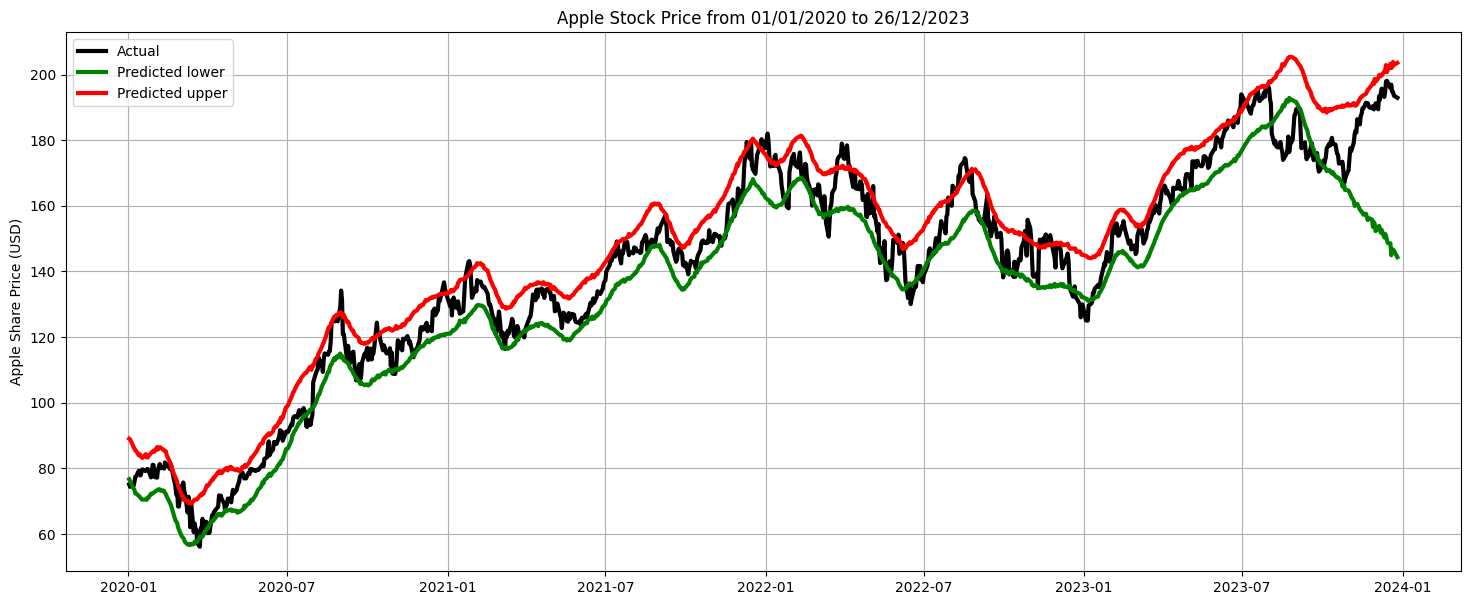

In [30]:
import matplotlib
import matplotlib.pyplot as plt

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 7)

plt.plot(data['Date'], data['Close'], linestyle='-', label="Actual",linewidth=3, color='black')
plt.plot(pred_forecast['ds'], pred_forecast['yhat_lower'],linestyle='-', label="Predicted lower",linewidth=3, color='green')
plt.plot(pred_forecast['ds'], pred_forecast['yhat_upper'],linestyle='-', label="Predicted upper",linewidth=3, color='red')
plt.grid(True)
plt.legend()
plt.title('Apple Stock Price from 01/01/2020 to 26/12/2023')
plt.ylabel('Apple Share Price (USD)')
plt.show()

In [ ]:
# To be modify
fig = go.Figure()
trace = go.Scatter(name = 'Actual price', mode = 'markers', x = list(df_forecast['ds']), y = list(needed_data['y']),
                   marker=dict(color='#FFBAD2',line=dict(width=1)))
trace1 = go.Scatter(name = 'trend', mode = 'lines', x = list(df_forecast['ds']), y = list(df_forecast['yhat']), 
                   marker=dict(color='red', line=dict(width=3)))
upper_band = go.Scatter(name = 'upper band', mode = 'lines', x = list(df_forecast['ds']), y = list(df_forecast['yhat_upper']),
                        line= dict(color='#57b88f'), fill = 'tonexty')
lower_band = go.Scatter(name= 'lower band', mode = 'lines', x = list(df_forecast['ds']), y = list(df_forecast['yhat_lower']),
                        line= dict(color='#1705ff'))
tracex = go.Scatter(name = 'Actual price', mode = 'markers', x = list(df0['ds']), y = list(df0['y']), 
                    marker=dict(color='black',line=dict(width=2)))

data = [tracex, trace1, lower_band, upper_band, trace]

layout = dict(title='Apple Stock Price Estimation Using FbProphet',
             xaxis=dict(title = 'Dates', ticklen=2, zeroline=True))

figure=dict(data=data,layout=layout)

plt.savefig('Apple Stock Price.png')

py.offline.iplot(figure)
#plt.show()